# **Dynamic Probit Modeling for Market Regime Prediction**




# **Introduction**

### **Objective of the Study**

In financial econometrics, predicting stock market regimes—whether bull or bear markets—is a critical challenge. This problem can be formulated as a binary time-series forecasting task, where we estimate the probability that the stock market experiences a positive or negative excess return.

Traditional econometric models often rely on static probit or logit models, which use contemporary predictors to estimate probabilities. However, empirical studies (e.g., Chauvet & Potter (2005), Kauppi & Saikkonen (2008), and Nyberg (2010)) have demonstrated that incorporating dynamic structures (lagged market states, autoregressive components) significantly improves forecast accuracy.

### **Why Probit Models?**

The probit model is a natural choice for binary response data, assuming an underlying latent variable structure where:
- Yt is an unobserved continuous index capturing market conditions.
- If 𝑌𝑡∗ > 0 we observe 𝑌𝑡 = 1 (positive excess return).
- Otherwise, 𝑌𝑡 = 0 (negative excess return).

By assuming that the error term follows a normal distribution, we derive the probit model, which estimates probabilities using the cumulative normal distribution function (Φ).

### **Types of Probit Models Implemented**

We estimate four different specifications:

1. **Static Probit Model:** Uses only contemporary predictors.
2. **Dynamic Probit Model (𝑌𝑡):** Adds lagged market state variables.
3. **Dynamic Probit Model (𝜋𝑡):** Includes lagged predicted probabilities to capture persistence.
4. **Complete Autoregressive Probit Model:** Combines both lagged market states and probabilities for a more sophisticated structure.


In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn fredapi


In [ ]:
!pip install ace_tools

### **2. Data Collection and Preprocessing**

**2.1. Variables Definition**

The dependent variable is a binary indicator of excess stock market returns:


The explanatory variables include:

**Market Indicators:**

- Log returns of S&P 500 (SP500): Captures overall stock market performance.

- VIX Index (market volatility proxy): Measures market uncertainty.

- Market Dividend Yield: Reflects valuation trends.

Macroeconomic Indicators:

- Inflation (Consumer Price Index, CPI): Represents macroeconomic stability.

- Credit Default Spread (DSPR): Measures risk premium on corporate bonds.

- Long-term interest rates (10-year Treasury Yield, LT_RATE): Captures monetary policy stance.

Dynamic Variables:

- Lagged values of Y_t: Captures past market states.

- Lagged values of π_t (Probit probability): Introduces autoregressive structure.



### **2.2. Data Retrieval**

Financial data is obtained from Yahoo Finance, and macroeconomic indicators are sourced from FRED API:

In [ ]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
import statsmodels.api as sm
import pandas as pd


In [ ]:
# Define analysis period
start_date = '2000-01-01'
end_date = '2024-01-01'

# FRED API key
API_KEY = 'f174cfc44bce7bf06b8b02addd38e6b4'
fred = Fred(api_key=API_KEY)

# Define stock indices
tickers = {
    'SP500': '^GSPC',
    'VIX': '^VIX',

}

# Download stock market data
df_market = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
df_market.columns = tickers.keys()

# Retrieve macroeconomic data from FRED
data_macro = {
    'LT_RATE': fred.get_series('GS10', start_date),
    'IND_PROD': fred.get_series('INDPRO', start_date),
    'DSPR': fred.get_series('BAMLH0A0HYM2', start_date),

}

df_macro = pd.DataFrame(data_macro)

# Merge datasets and drop missing values
df = df_market.merge(df_macro, left_index=True, right_index=True, how='inner').dropna()
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


,SP500,VIX,LT_RATE,IND_PROD,DSPR
2000-02-01,1409.280029,23.450001,6.52,91.7245,4.87
2000-03-01,1379.189941,21.639999,6.26,92.0830,5.11
2000-05-01,1468.250000,25.879999,6.44,92.9347,5.83
2000-06-01,1448.810059,22.360001,6.10,93.0018,6.22
2000-08-01,1438.099976,20.549999,5.83,92.5910,6.31


### **2.3. Exploratory Data Analysis**

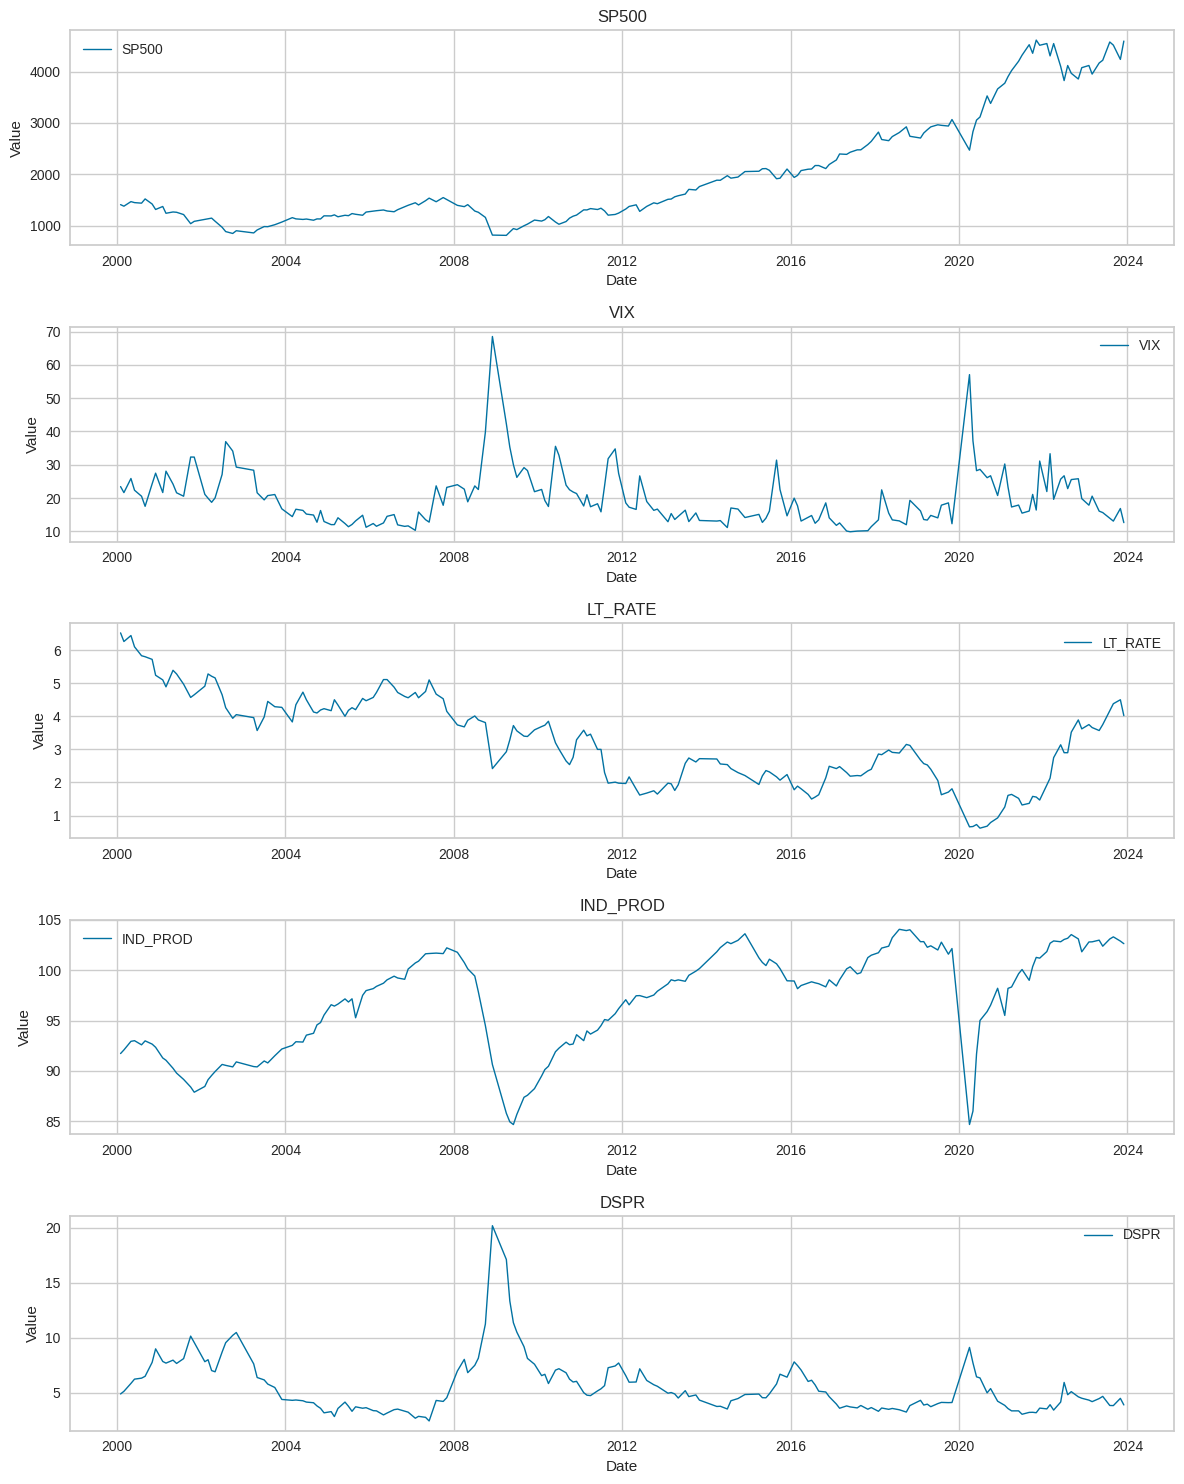

In [ ]:
# Définir la taille de la figure
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(12, 3 * len(df.columns)))

# Vérifier si on a plusieurs variables à tracer
if len(df.columns) > 1:
    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], label=column, linewidth=1)
        axes[i].set_title(column)
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Value")
        axes[i].legend()
        axes[i].grid(True)
else:
    column = df.columns[0]
    axes.plot(df.index, df[column], label=column, linewidth=1)
    axes.set_title(column)
    axes.set_xlabel("Date")
    axes.set_ylabel("Value")
    axes.legend()
    axes.grid(True)

# Ajuster la disposition des graphiques
plt.tight_layout()
plt.show()


## **3. Data Pre-Processing**



### **3.1 Data Transformation**

In [ ]:
# Compute log returns for S&P 500
df['RE'] = np.log(df['SP500'] / df['SP500'].shift(1))

# Define binary target variable: 1 if return >= 0, otherwise 0
df['Y_t'] = (df['RE'] >= 0).astype(int)

In [ ]:
# Apply log transformation where necessary
df['log_IND_PROD'] = np.log(df['IND_PROD'])
df['log_VIX'] = np.log(df['VIX'])



## **3.2. Stationarity Testing**

In [ ]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not Stationary")

for col in ['RE', 'log_IND_PROD', 'LT_RATE', 'DSPR', 'log_VIX']:
    adf_test(df[col], col)



ADF Test for RE:
ADF Statistic: -13.5769, p-value: 0.0000
Stationary

ADF Test for log_IND_PROD:
ADF Statistic: -2.5262, p-value: 0.1092
Not Stationary

ADF Test for LT_RATE:
ADF Statistic: -2.4714, p-value: 0.1226
Not Stationary

ADF Test for DSPR:
ADF Statistic: -3.6677, p-value: 0.0046
Stationary

ADF Test for log_VIX:
ADF Statistic: -4.0655, p-value: 0.0011
Stationary


## **3.3 First Diff**

In [ ]:
# Differenciation
df['RE'] = df['RE'].diff()
df['DSPR'] = df['DSPR'].diff()
df['IND_PROD'] = df['log_IND_PROD'].diff()
df['VIX'] = df['log_VIX'].diff()
df['LT_RATE'] = df['LT_RATE'].diff()



In [ ]:
for col in ['RE', 'IND_PROD', 'DSPR', 'VIX','LT_RATE']:
    adf_test(df[col], col)


ADF Test for RE:
ADF Statistic: -7.1603, p-value: 0.0000
Stationary

ADF Test for IND_PROD:
ADF Statistic: -12.4764, p-value: 0.0000
Stationary

ADF Test for DSPR:
ADF Statistic: -10.3371, p-value: 0.0000
Stationary

ADF Test for VIX:
ADF Statistic: -9.4257, p-value: 0.0000
Stationary

ADF Test for LT_RATE:
ADF Statistic: -11.8465, p-value: 0.0000
Stationary


### **3.4. Multicolinearity Test**

a) VIF

b) Correlation Matrix

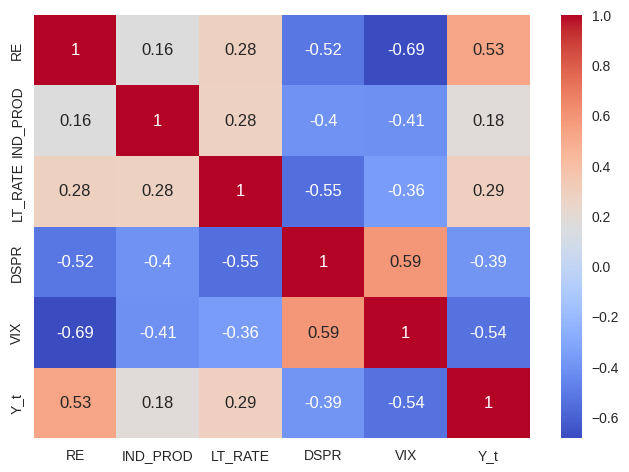

In [ ]:
corr_matrix = df[['RE', 'IND_PROD', 'LT_RATE', 'DSPR', 'VIX', 'Y_t']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

## **4. Probit Model Estimation**


In [ ]:
# Définition de la plage de lags à tester
max_lags = 10
aic_results = {}
bic_results = {}

# Test des différents nombres de lags
for lags in range(1, max_lags + 1):
    df_temp = df.copy()

    # Ajouter les lags de Y_t
    for i in range(1, lags + 1):
        df_temp[f'Y_t-{i}'] = df_temp['Y_t'].shift(i)

    # Supprimer les valeurs manquantes
    df_temp.dropna(inplace=True)
    # Définition des variables explicatives
    X_lag_selection = df_temp[['IND_PROD', 'LT_RATE', 'DSPR', 'VIX', ] + [f'Y_t-{i}' for i in range(1, lags + 1)]]
    X_lag_selection = sm.add_constant(X_lag_selection)

    # Estimation du modèle Probit
    model = sm.Probit(df_temp['Y_t'], X_lag_selection).fit(disp=0)

    # Stocker les valeurs AIC et BIC
    aic_results[lags] = model.aic
    bic_results[lags] = model.bic

# Affichage des résultats
aic_bic_df = pd.DataFrame({'AIC': aic_results, 'BIC': bic_results})
display(aic_bic_df)


,AIC,BIC
1,173.795370,193.084984
2,175.582519,198.087069
3,175.351101,201.026991
4,170.926301,199.762361
5,171.867801,203.852771
6,172.260888,207.383413
7,173.289395,211.538025
8,173.053261,214.416448
9,173.789171,218.255267
10,173.523108,221.080368


### **4.1. Static Probit Model**


In [ ]:
# Lagging only the explanatory variables
Best = 1
df['IND_PROD_L1'] = df['IND_PROD'].shift(Best)
df['LT_RATE_L1'] = df['LT_RATE'].shift(Best)
df['DSPR_L1'] = df['DSPR'].shift(Best)
df['VIX_L1'] = df['VIX'].shift(Best)

# Drop missing values due to lagging
df.dropna(inplace=True)

# Define the explanatory variable set (now lagged)
X_static = df[['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1']]
X_static = sm.add_constant(X_static)

# Estimate the Probit model
probit_static = sm.Probit(df['Y_t'], X_static).fit()
print(probit_static.summary())


Optimization terminated successfully.
         Current function value: 0.651954
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    Y_t   No. Observations:                  184
Model:                         Probit   Df Residuals:                      179
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                 0.02236
Time:                        20:13:09   Log-Likelihood:                -119.96
converged:                       True   LL-Null:                       -122.70
Covariance Type:            nonrobust   LLR p-value:                    0.2409
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2896      0.095      3.049      0.002       0.103       0.476
IND_PROD_L1    -2.1979    

In [ ]:
df['Probit_Static'] = probit_static.predict(X_static)

In [ ]:
marginal_effects = probit_static.get_margeff(method="dydx", at="mean")
print(marginal_effects.summary())

       Probit Marginal Effects       
Dep. Variable:                    Y_t
Method:                          dydx
At:                              mean
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
IND_PROD_L1    -0.8394      2.497     -0.336      0.737      -5.733       4.054
LT_RATE_L1     -0.2503      0.150     -1.665      0.096      -0.545       0.044
DSPR_L1        -0.1048      0.050     -2.078      0.038      -0.204      -0.006
VIX_L1          0.1430      0.181      0.789      0.430      -0.212       0.498


### **4.2. Dynamic Probit Model (Lagged 𝑌𝑡)**

---



In [ ]:
import statsmodels.api as sm

# Ajouter le lag de la variable dépendante Y_t
df['Y_t_L1'] = df['Y_t'].shift(1)

# Supprimer les valeurs NaN après le décalage
df.dropna(inplace=True)

# Définir les variables explicatives avec Y_t-1
X_dynamic_Y = df[['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'Y_t_L1']]
X_dynamic_Y = sm.add_constant(X_dynamic_Y)

# Estimer le modèle Probit dynamique
probit_dynamic_Y = sm.Probit(df['Y_t'], X_dynamic_Y).fit()
print(probit_dynamic_Y.summary())


Optimization terminated successfully.
         Current function value: 0.642685
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    Y_t   No. Observations:                  173
Model:                         Probit   Df Residuals:                      167
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                 0.02465
Time:                        20:13:39   Log-Likelihood:                -111.18
converged:                       True   LL-Null:                       -113.99
Covariance Type:            nonrobust   LLR p-value:                    0.3451
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5098      0.192      2.654      0.008       0.133       0.886
IND_PROD_L1    -4.2588    

In [ ]:
df['Probit_Dynamic_Y'] = probit_dynamic_Y.predict(X_dynamic_Y)

In [ ]:
# Calculer les effets marginaux
marginal_effects = probit_dynamic_Y.get_margeff()
print(marginal_effects.summary())

       Probit Marginal Effects       
Dep. Variable:                    Y_t
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
IND_PROD_L1    -1.5645      2.475     -0.632      0.527      -6.415       3.286
LT_RATE_L1     -0.2116      0.149     -1.420      0.156      -0.504       0.080
DSPR_L1        -0.1023      0.050     -2.063      0.039      -0.200      -0.005
VIX_L1         -0.0023      0.200     -0.011      0.991      -0.394       0.390
Y_t_L1         -0.1017      0.093     -1.090      0.276      -0.285       0.081


### **4.3. Dynamic Probit Model (Including Lagged 𝜋𝑡)**

In [ ]:
df['pi_t'] = probit_dynamic_Y.predict(X_dynamic_Y)

df['pi_t_L1'] = df['pi_t'].shift(1)

df.dropna(inplace=True)

X_dynamic_pi = df[['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'pi_t_L1']]
X_dynamic_pi = sm.add_constant(X_dynamic_pi)

probit_dynamic_pi = sm.Probit(df['Y_t'], X_dynamic_pi).fit()
print(probit_dynamic_pi.summary())


Optimization terminated successfully.
         Current function value: 0.643253
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    Y_t   No. Observations:                  172
Model:                         Probit   Df Residuals:                      166
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                 0.02084
Time:                        20:13:45   Log-Likelihood:                -110.64
converged:                       True   LL-Null:                       -112.99
Covariance Type:            nonrobust   LLR p-value:                    0.4522
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1339      0.766      0.175      0.861      -1.368       1.636
IND_PROD_L1    -4.0459    

In [ ]:
df['Probit_Dynamic_Pi'] = probit_dynamic_pi.predict(X_dynamic_pi)

In [ ]:
marginal_effects_dynamic_pi = probit_dynamic_pi.get_margeff(method="dydx", at="mean")
print(marginal_effects_dynamic_pi.summary())


       Probit Marginal Effects       
Dep. Variable:                    Y_t
Method:                          dydx
At:                              mean
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
IND_PROD_L1    -1.5188      2.604     -0.583      0.560      -6.622       3.585
LT_RATE_L1     -0.2347      0.156     -1.503      0.133      -0.541       0.071
DSPR_L1        -0.0959      0.051     -1.900      0.057      -0.195       0.003
VIX_L1          0.0865      0.182      0.474      0.635      -0.271       0.444
pi_t_L1         0.1259      0.454      0.277      0.782      -0.764       1.016


## **4.4. Complete Autoregressive Probit Model**

---



In [ ]:
# Définition du jeu de données pour le Probit Autorégressif Complet
X_full = df[['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'Y_t_L1', 'pi_t_L1']]
X_full = sm.add_constant(X_full)

# Estimation du modèle Probit Autorégressif Complet
probit_full = sm.Probit(df['Y_t'], X_full).fit()

# Stocker les probabilités prédites dans df
df['Probit_Full'] = probit_full.predict(X_full)

# Afficher le résumé du modèle
print(probit_full.summary())



Optimization terminated successfully.
         Current function value: 0.638149
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    Y_t   No. Observations:                  172
Model:                         Probit   Df Residuals:                      165
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                 0.02861
Time:                        20:13:52   Log-Likelihood:                -109.76
converged:                       True   LL-Null:                       -112.99
Covariance Type:            nonrobust   LLR p-value:                    0.3731
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2310      0.791      0.292      0.770      -1.320       1.782
IND_PROD_L1    -5.2020    

In [ ]:
# Stocker les probabilités prédites dans df
df['Probit_Full'] = probit_full.predict(X_full)

In [ ]:
marginal_effects_full = probit_full.get_margeff(method="dydx", at="mean")
print(marginal_effects_full.summary())


       Probit Marginal Effects       
Dep. Variable:                    Y_t
Method:                          dydx
At:                              mean
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
IND_PROD_L1    -1.9495      2.572     -0.758      0.448      -6.991       3.092
LT_RATE_L1     -0.2281      0.156     -1.459      0.144      -0.534       0.078
DSPR_L1        -0.1056      0.053     -1.999      0.046      -0.209      -0.002
VIX_L1         -0.0371      0.206     -0.180      0.857      -0.442       0.367
Y_t_L1         -0.1288      0.098     -1.315      0.188      -0.321       0.063
pi_t_L1         0.1992      0.467      0.426      0.670      -0.717       1.115


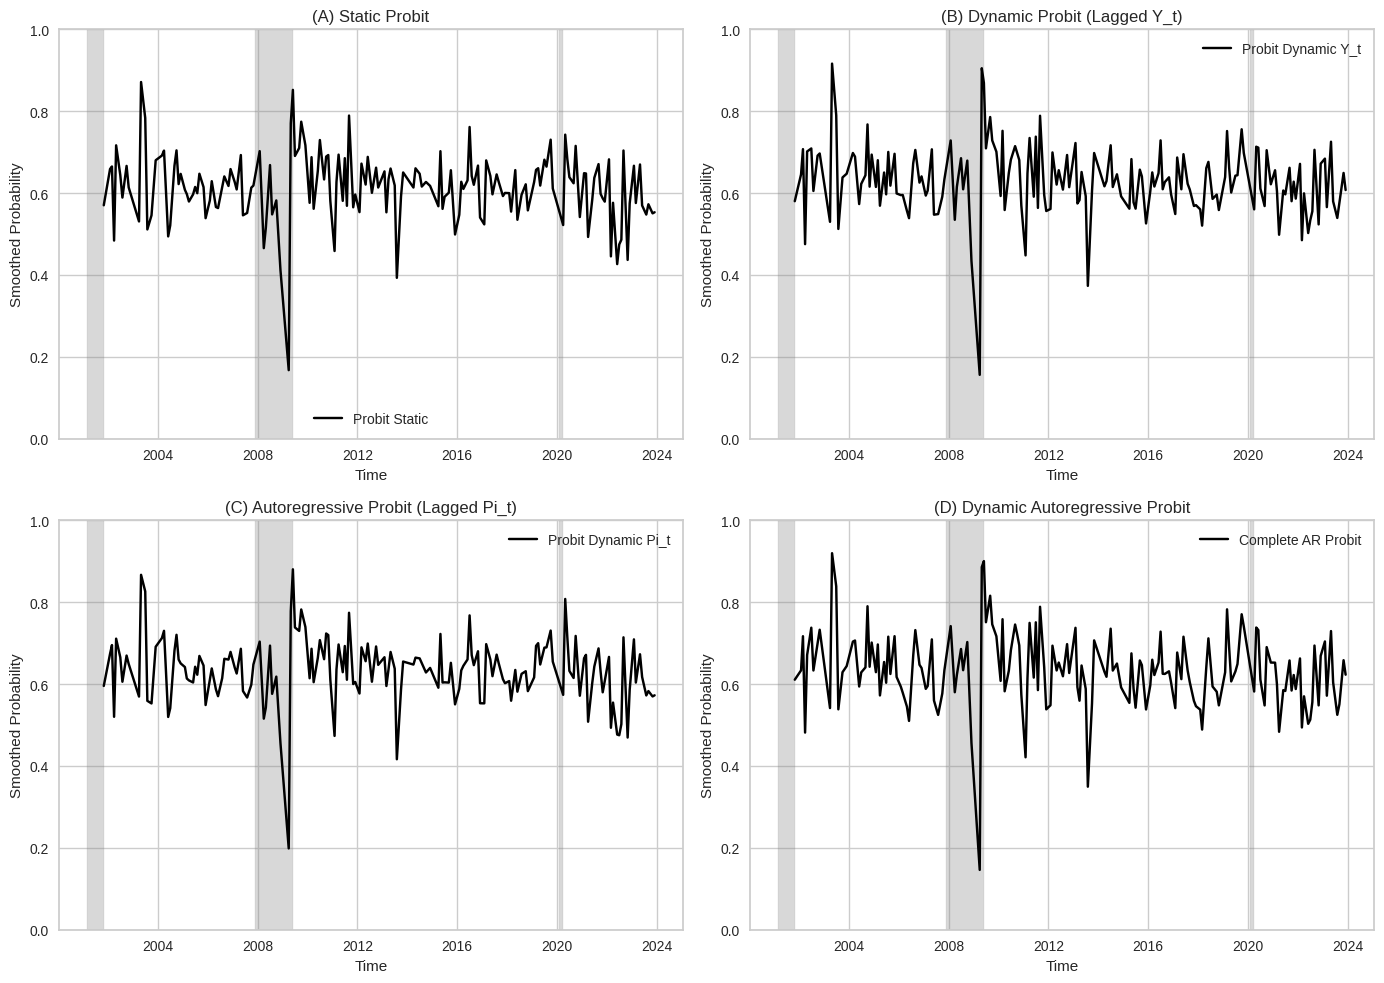

In [ ]:
# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df.index)

# Compute predicted probabilities for each model with smoothing
df['Probit_Static_Smoothed'] = df['Probit_Static']
df['Probit_Dynamic_Y_Smoothed'] = df['Probit_Dynamic_Y']
df['Probit_Dynamic_Pi_Smoothed'] = df['Probit_Dynamic_Pi']
df['Probit_Full_Smoothed'] = df['Probit_Full']

# Define NBER recession periods manually
recession_periods = [
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01')
]

# Create subplots for the four models
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Function to plot each model
def plot_model(ax, title, column, label):
    ax.plot(df['Date'], df[column], color='black', label=label)
    for start, end in recession_periods:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)  # Shade recession periods
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.legend()

# Static Probit Model
plot_model(axs[0, 0], '(A) Static Probit', 'Probit_Static_Smoothed', 'Probit Static')

# Dynamic Probit Model (Lagged Y_t)
plot_model(axs[0, 1], '(B) Dynamic Probit (Lagged Y_t)', 'Probit_Dynamic_Y_Smoothed', 'Probit Dynamic Y_t')

# Dynamic Probit Model (Lagged Pi_t)
plot_model(axs[1, 0], '(C) Autoregressive Probit (Lagged Pi_t)', 'Probit_Dynamic_Pi_Smoothed', 'Probit Dynamic Pi_t')

# Complete Autoregressive Probit Model
plot_model(axs[1, 1], '(D) Dynamic Autoregressive Probit', 'Probit_Full_Smoothed', 'Complete AR Probit')

# Formatting
for ax in axs.flat:
    ax.set_xlabel('Time')
    ax.set_ylabel('Smoothed Probability')
    ax.grid(True)

plt.tight_layout()
plt.show()


## **5. Model Evaluation**

### **5.1. Model Comparison**

In [ ]:
print(f"AIC - Static: {probit_static.aic}")
print(f"AIC - Dynamic (Y_t): {probit_dynamic_Y.aic}")
print(f"AIC - Dynamic (Pi_t): {probit_dynamic_pi.aic}")
print(f"AIC - Complete AR Probit: {probit_full.aic}")

AIC - Static: 249.91892137243184
AIC - Dynamic (Y_t): 234.36903661184897
AIC - Dynamic (Pi_t): 233.27896678404505
AIC - Complete AR Probit: 233.52339675277324


### **5.2. ROC Curve Analysis**

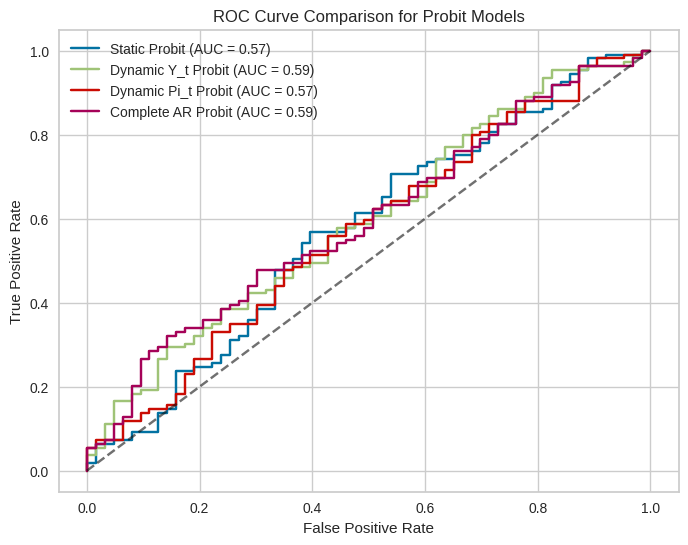

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define models in a structured way
models = {
    'Static Probit': (probit_static, X_static),
    'Dynamic Y_t Probit': (probit_dynamic_Y, X_dynamic_Y),
    'Dynamic Pi_t Probit': (probit_dynamic_pi, X_dynamic_pi),
    'Complete AR Probit': (probit_full, X_full)
}

# Initialize figure
plt.figure(figsize=(8, 6))
auc_values = {}

# Loop through models and compute ROC
for model_name, (probit_model, X) in models.items():
    # Align Y_t and X indices
    X = X.dropna()
    common_index = df.index.intersection(X.index)
    y_true, X = df.loc[common_index, 'Y_t'], X.loc[common_index]

    # Predict probabilities & compute ROC curve
    y_pred_prob = probit_model.predict(X)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    auc_values[model_name] = roc_auc

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)

# Formatting
plt.legend()
plt.title("ROC Curve Comparison for Probit Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()



## Why not linear regression (Confirmation)

In [ ]:
import statsmodels.api as sm

X_linear = df[['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'Y_t_L1', 'pi_t_L1']]
X_linear = sm.add_constant(X_linear)
linear_model = sm.OLS(df['Y_t'], X_linear).fit()



In [ ]:
print(f"AIC - Probit: {probit_full.aic:.2f}")
print(f"AIC - Régression Linéaire: {linear_model.aic:.2f}")


AIC - Probit: 233.52
AIC - Régression Linéaire: 244.72


# Part 2 : ML Extention

In [ ]:
!pip install pycaret


  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)


In [ ]:
import os
os._exit(00)


In [ ]:
from pycaret.classification import *

In [ ]:
# Selecting features (same as those used in the Probit model)
features = ['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'Y_t_L1', 'pi_t_L1']

# Creating dataset with target variable
df_model = df[features + ['Y_t']].dropna()  # Removing missing values


In [ ]:
# Initialize PyCaret without 'silent' (use 'verbose' instead)
clf = setup(df_model,
            target='Y_t',
            session_id=123,
            normalize=True,
            verbose=False)

In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6583,0.6365,0.7768,0.7136,0.7355,0.2283,0.2376,0.1460
ada,Ada Boost Classifier,0.6417,0.6238,0.7357,0.7146,0.7180,0.2221,0.2299,0.1010
xgboost,Extreme Gradient Boosting,0.6333,0.6514,0.7321,0.6991,0.7100,0.1843,0.1830,0.1050
lightgbm,Light Gradient Boosting Machine,0.6333,0.6230,0.7786,0.6856,0.7223,0.1710,0.1794,0.1750
dummy,Dummy Classifier,0.6333,0.5000,1.0000,0.6333,0.7747,0.0000,0.0000,0.0250
rf,Random Forest Classifier,0.6250,0.6207,0.8000,0.6697,0.7229,0.1314,0.1501,0.1790
knn,K Neighbors Classifier,0.6167,0.5770,0.7554,0.6787,0.7085,0.1479,0.1631,0.0420
lr,Logistic Regression,0.6083,0.5291,0.9089,0.6338,0.7440,0.0068,0.0115,0.7320
ridge,Ridge Classifier,0.6083,0.5288,0.8946,0.6356,0.7408,0.0129,0.0165,0.0480
gbc,Gradient Boosting Classifier,0.6083,0.5695,0.7214,0.6720,0.6905,0.1393,0.1525,0.1170


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
et_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7286,0.7143,0.7143,0.7143,0.3143,0.3143
1,0.7500,0.8143,0.7143,0.8333,0.7692,0.5000,0.5071
2,0.6667,0.5429,0.8571,0.6667,0.7500,0.2727,0.2928
3,0.6667,0.6857,0.8571,0.6667,0.7500,0.2727,0.2928
4,0.4167,0.4531,0.3750,0.6000,0.4615,-0.1053,-0.1195
5,0.5833,0.6562,0.7500,0.6667,0.7059,0.0000,0.0000
6,0.8333,0.7500,0.8750,0.8750,0.8750,0.6250,0.6250
7,0.6667,0.5938,0.7500,0.7500,0.7500,0.2500,0.2500
8,0.5833,0.5781,0.8750,0.6364,0.7368,-0.1538,-0.2132


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Import PyCaret
from pycaret.classification import *

# Définir les features et la variable cible
features = ['IND_PROD_L1', 'LT_RATE_L1', 'DSPR_L1', 'VIX_L1', 'Y_t_L1', 'pi_t_L1']
target = 'Y_t'

# Création du dataset (supprime les valeurs NaN pour éviter les erreurs)
df_model = df[features + [target]].dropna()

# Initialiser PyCaret (Remplace silent=True par verbose=False)
clf_setup = setup(data=df_model, target=target, session_id=123, verbose=False)

# Créer le modèle Extra Trees
et_model = create_model('et')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7286,0.7143,0.7143,0.7143,0.3143,0.3143
1,0.7500,0.8143,0.7143,0.8333,0.7692,0.5000,0.5071
2,0.6667,0.5429,0.8571,0.6667,0.7500,0.2727,0.2928
3,0.6667,0.6857,0.8571,0.6667,0.7500,0.2727,0.2928
4,0.4167,0.4531,0.3750,0.6000,0.4615,-0.1053,-0.1195
5,0.5833,0.6562,0.7500,0.6667,0.7059,0.0000,0.0000
6,0.8333,0.7500,0.8750,0.8750,0.8750,0.6250,0.6250
7,0.6667,0.5938,0.7500,0.7500,0.7500,0.2500,0.2500
8,0.5833,0.5781,0.8750,0.6364,0.7368,-0.1538,-0.2132


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

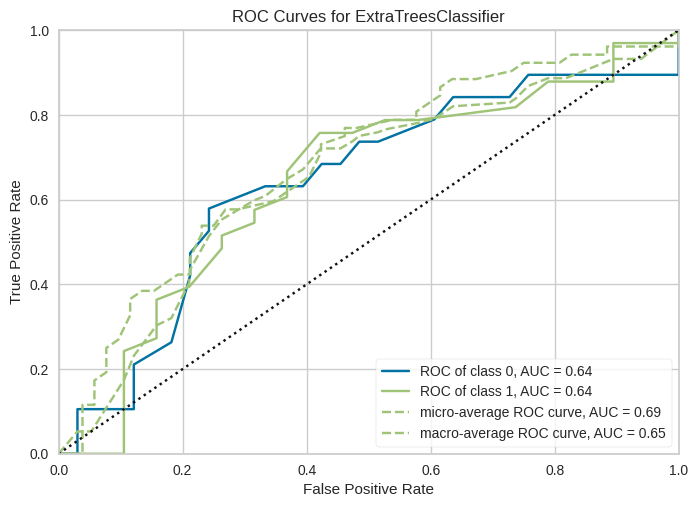

In [ ]:
# Tracer la courbe ROC
plot_model(et_model, plot='auc')


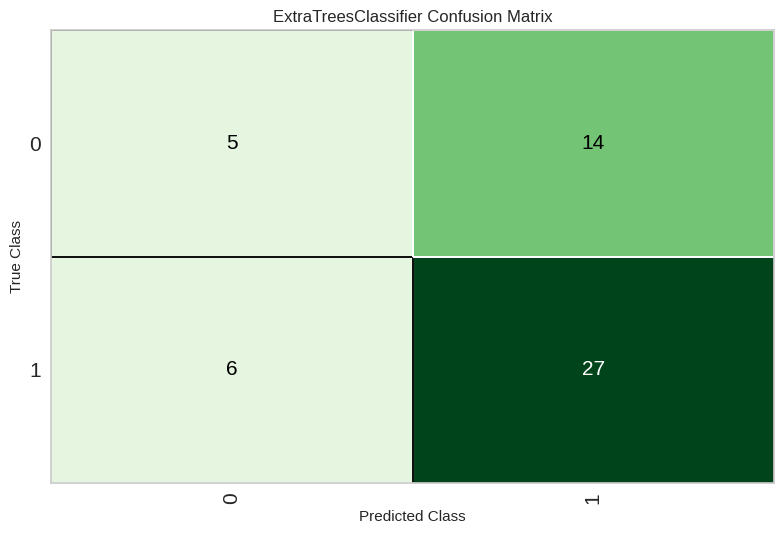

In [ ]:
# Tracer la matrice de confusion
plot_model(et_model, plot='confusion_matrix')


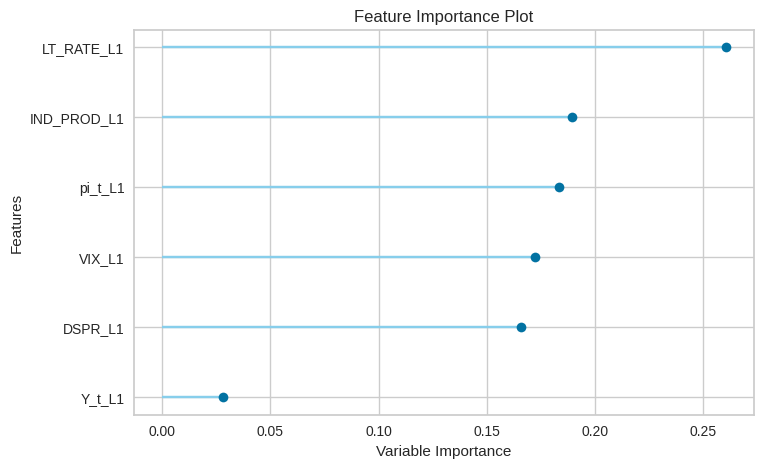

In [ ]:
# Tracer l'importance des features
plot_model(et_model, plot='feature')

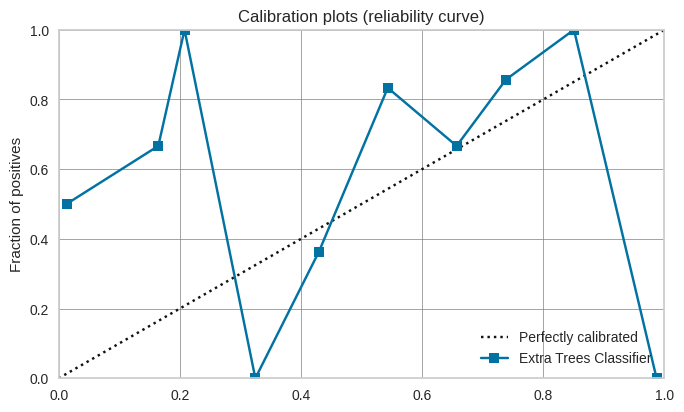

In [ ]:
# Tracer la courbe de calibration
plot_model(et_model, plot='calibration')